### 0. Imports and setup

In [2]:
from src.dataset import Colored3DMNIST, DataLoader
from torchvision import transforms, datasets
from IPython.display import clear_output
from src.nn import UNet, ResNet_D
from src.plot import plot_img_3D
from src.plot import plot_img
from pathlib import Path
from tqdm import tqdm

import torch.nn.functional as F
import matplotlib.pyplot as plt
import src.data as data
import torch.nn as nn
import numpy as np
import torchvision
import torch
import gc

In [3]:
if torch.cuda.is_available():
    torch.cuda.set_device(f"cuda:0")
torch.manual_seed(0)
np.random.seed(0)

### 1. Getting the data ready

In [4]:
BATCH_SIZE = 16
TRANSFORM_3D = transforms.ToTensor()

x_train_a = np.load(file='./data/x_train_a_c.npy')
mnist_train_a = Colored3DMNIST(x_train_a)
mnist_loader_a = torch.utils.data.DataLoader(mnist_train_a, batch_size=BATCH_SIZE, shuffle=True)
                                             
x_train_b = np.load(file='./data/x_train_b_c.npy')
mnist_train_b = Colored3DMNIST(x_train_a)
mnist_loader_b = torch.utils.data.DataLoader(mnist_train_b, batch_size=BATCH_SIZE, shuffle=True)

x_test = np.load(file='./data/x_test_c.npy')
mnist_test = Colored3DMNIST(x_test)
mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)

Let's plot a number:

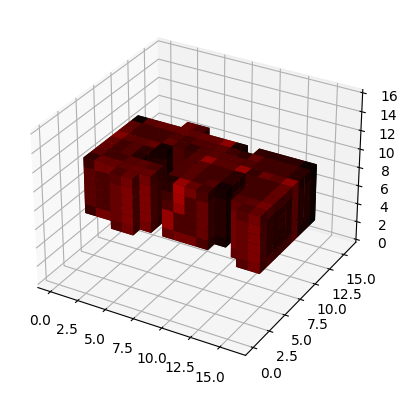

In [5]:
img = next(iter(mnist_loader_test))
plot_img(img[0])
plot_img_3D(img[0])


### 3. Preparation for the training

In [6]:
# Taken from https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/src/tools.py
def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

In [7]:
f = ResNet_D(16, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3).cuda()

In [8]:
iter_train_a = iter(mnist_loader_a)
iter_train_b = iter(mnist_loader_b)
iter_test = iter(mnist_loader_test)

def sample_train_a():
    global mnist_loader_a, iter_train_a
    try:
        return next(iter_train_a).float()
    except StopIteration:
        iter_train_a = iter(mnist_loader_a)
        return next(iter_train_a).float()

def sample_train_b():
    global mnist_loader_b, iter_train_b
    try:
        return next(iter_train_b).float()
    except StopIteration:
        iter_train_b = iter(mnist_loader_b)
        return next(iter_train_b).float()

def sample_test():
    global mnist_loader_test, iter_test
    try:
        return next(iter_test).float()
    except StopIteration:
        iter_test = iter(mnist_loader_test)
        return next(iter_test).float()

In [9]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-5, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

In [10]:
def save_model(e, t, F, o_t, o_F, l_t, l_F, path):
    torch.save({
                'epoch': e,
                'T_state_dict': t.state_dict(),
                'f_state_dict': F.state_dict(),
                'T_optimizer_state_dict': o_t.state_dict(),
                'f_optimizer_state_dict': o_F.state_dict(),
                'T_loss': l_t,
                'f_loss': l_F
                }, path)

def load_model(F, t, o_t, o_F, path):
    checkpoint = torch.load(path)

    F.load_state_dict(checkpoint["f_state_dict"])
    t.load_state_dict(checkpoint["T_state_dict"])
    o_F.load_state_dict(checkpoint["f_optimizer_state_dict"])
    o_t.load_state_dict(checkpoint["T_optimizer_state_dict"])
    
    return checkpoint["epoch"], F, t, o_F, o_t, checkpoint["T_loss"], checkpoint["f_loss"]

step, f, T, T_opt, f_opt, T_loss, f_loss = load_model(f, T, T_opt, f_opt, "weights/OT_kaggle_rotated_7000.pt")

### 4. Training loop

In [16]:
def sq_cost(X, Y):
  return (X-Y).square().flatten(start_dim=1).mean(dim=1)

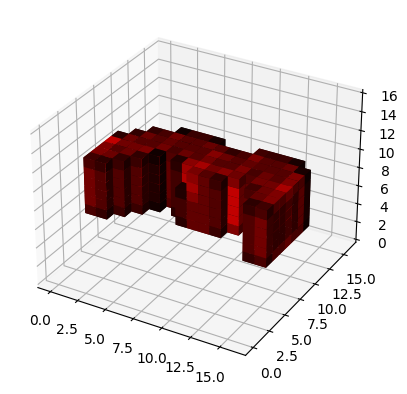

  0%|          | 0/15001 [00:00<?, ?it/s]

In [11]:
test_batch = sample_test()
plot_img(test_batch[0])
f_losses = []
T_losses = []

imgs = []

for step in tqdm(range(15001)):
    # clear_output(wait=True)

    # Training T, freezing fDagor EnDagor Enginegine
    T.train(True)
    f.eval()
    
    for i in range(10):
        X = sample_train_a().cuda()

        T_X = T(X)
        T_loss = sq_cost(X, T_X).mean() - f(T_X).mean()
        T_opt.zero_grad()
        T_loss.backward()
        T_opt.step()
    

    # Training f, freezing T
    f.train(True)
    T.eval()

    X = sample_train_a().cuda()
    Y = sample_train_b().cuda()

    with torch.no_grad():
        T_x = T(X)
    
    f_loss = f(T_x).mean() - f(Y).mean()
    f_opt.zero_grad()
    f_loss.backward()
    f_opt.step()

    if not step % 100:
        print(f"T_loss: {T_loss}; ", end="")
        print(f" f_loss: {f_loss}")
        T_X = torch.clip(T(test_batch.cuda())[0].cpu().detach(), min=0, max=1)
        T_X[T_X < np.quantile(T_X, 0.92)] = 0
        plot_img(T_X)

    # Save OT map every 1000 steps
    if not step % 1000:
        save_model(step, T, f, T_opt, f_opt, T_loss, f_loss, f"weights/OT_kaggle_rotated_{step}.pt")

    gc.collect()
    torch.cuda.empty_cache()

In [15]:
test_batch = sample_test().cuda()

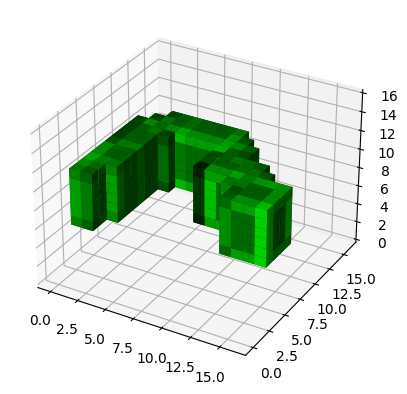

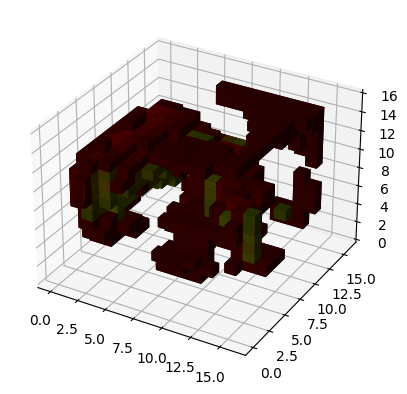

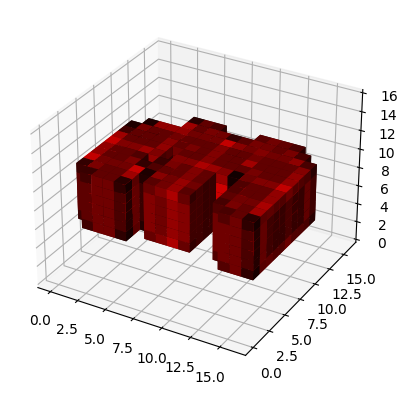

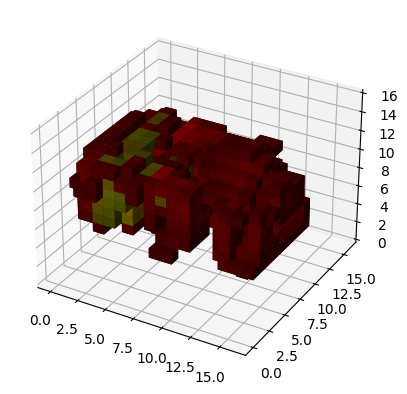

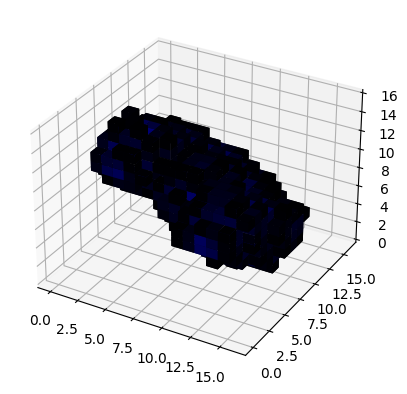

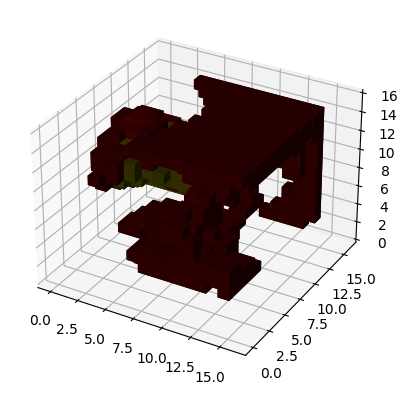

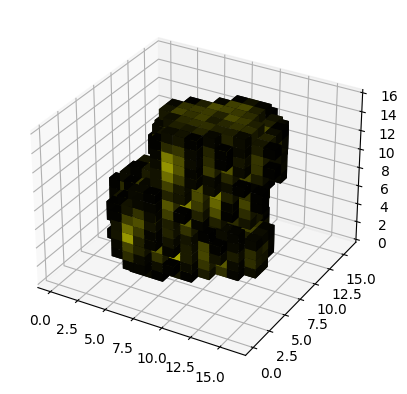

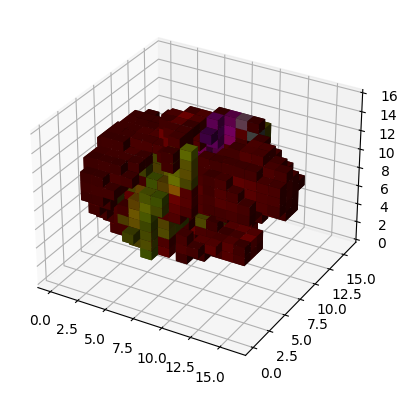

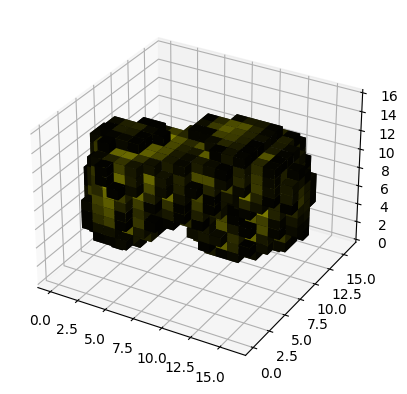

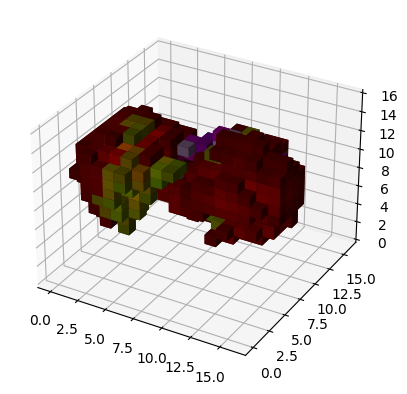

In [16]:
for i in range(5):
    plot_img(test_batch[i].cpu())

    T_X = torch.clip(T(test_batch)[i].cpu().detach(), min=0, max=1)
    T_X[T_X < np.quantile(T_X, 0.92)] = 0
    plot_img(T_X)